**Find Edges**

In [1]:
##Find edges
import skimage.io as io
io.use_plugin('tifffile')

#Load image
im = io.imread('C:/Users/David Brown/Documents/Huang Lab/Exp0104_KDM5A_PHD2-fragments/Well02_HeLa_PHD2-IDR-PHD3_1/Well02_HeLa_PHD2-IDR-PHD3_1.tif')
mask4=io.imread('C:/Users/David Brown/Documents/Huang Lab/Exp0104_KDM5A_PHD2-fragments/Well02_HeLa_PHD2-IDR-PHD3_1/Well02_HeLa_PHD2-IDR-PHD3_1_Hoechst_Local_Otsu.tif')
#Slice1 contains ~58 nuclei, 52 not touching the border

#Select Hoechst stack
Hoechst_stack = im[:,:,:,0]

In [2]:
#Set scale
z_size, x_size, y_size = Hoechst_stack.shape

z_scale = 0.26 # µm per plane for 100x NIC confocal images
xy_scale = 0.065 # µm per pixel for 100x NIC confocal images

In [3]:
##Load mask5
import numpy as np
mask5=np.load('C:/Users/David Brown/Documents/Huang Lab/Exp0104_KDM5A_PHD2-fragments/Well02_HeLa_PHD2-IDR-PHD3_1/Well02_HeLa_PHD2-IDR-PHD3_1_Hoechst_Local_Otsu_3D_Gaussian_Intersect.npy')

(<matplotlib.axes._subplots.AxesSubplot at 0x83de860>,
 <matplotlib.text.Text at 0x848b588>)

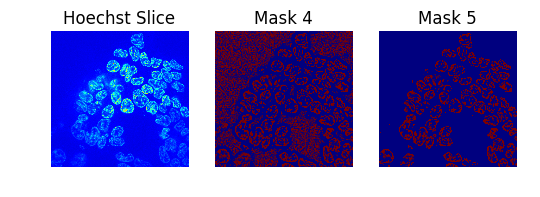

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

z=4

plt.subplot(1,3,1),plt.imshow(Hoechst_stack[z])
plt.subplot(1,3,1),plt.axis('off')
plt.subplot(1,3,1),plt.title('Hoechst Slice')
plt.subplot(1,3,2),plt.imshow(mask4[z])
plt.subplot(1,3,2),plt.axis('off')
plt.subplot(1,3,2),plt.title('Mask 4')
plt.subplot(1,3,3),plt.imshow(mask5[z])
plt.subplot(1,3,3),plt.axis('off')
plt.subplot(1,3,3),plt.title('Mask 5')
#Note uneven illumination

In [5]:
##Try Labelling objects
import mahotas as mh

labeled_mask5, nr_objects=mh.label(mask5)

In [6]:
nr_objects

321410L

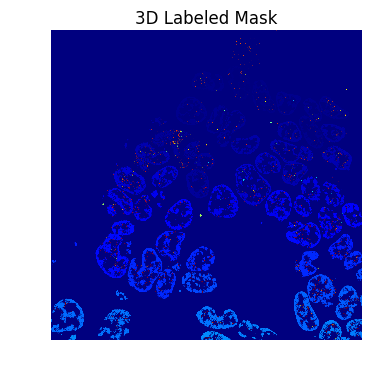

In [7]:
plt.imshow(labeled_mask5[z])
plt.axis('off')
plt.title('3D Labeled Mask')

In [8]:
##Remove small objects
from skimage import morphology

min_vol = 8000

#from skimage.morphology import remove_small_objects
real=morphology.remove_small_objects(labeled_mask5, min_vol)

In mahotas after version 1.4, we can even make many of the same operations with a single call to mh.labeled.filter_labeled:

relabeled,n_left = mh.labeled.filter_labeled(labeled, remove_bordering=True, max_size=10000)

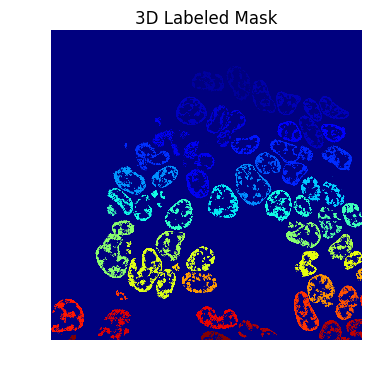

In [9]:
plt.imshow(real[z])
plt.axis('off')
plt.title('3D Labeled Mask')

In [10]:
##Count the labels, Reset counts (Maybe Randomize?), Find objects
relabeled, n_left = mh.labeled.relabel(real)
print('After filtering and relabeling, there are {} nuclei left.'.format(n_left))

After filtering and relabeling, there are 59 nuclei left.


In [12]:
relabeled.shape

(24L, 2048L, 2048L)

In [11]:
from scipy.ndimage import morphology
##Iterate through z-stack for each hulls, dilate/fill/erode to give filled regions.
#This may be extremely slow

In [32]:
#Let's start with one frame
test=relabeled[z]
final=np.zeros_like(test)

for l in range(test.max()):
    ll=l+1
    blob=morphology.binary_dilation(test==ll, np.ones((20,20)))
    filled_blob=morphology.binary_fill_holes(blob)
    reduced=morphology.binary_erosion(filled_blob, np.ones((20,20)))*ll
    final=final+reduced

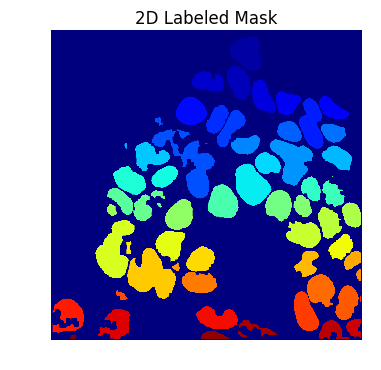

In [43]:
plt.imshow(final)
plt.axis('off')
plt.title('2D Labeled Mask')

In [16]:
#Let's do every z slice
final_stack=np.zeros_like(relabeled)
for z, frame in enumerate(relabeled):

    #Could remove on boarders at this point?
    final=np.zeros_like(frame)

    for l in range(frame.max()):
        ll=l+1
        blob=morphology.binary_dilation(frame==ll, np.ones((20,20)))
        filled_blob=morphology.binary_fill_holes(blob)
        reduced=morphology.binary_erosion(filled_blob, np.ones((20,20)))*ll
        final=final+reduced
    
    final_stack[z]=final    

(<matplotlib.axes._subplots.AxesSubplot at 0x610b7320>,
 <matplotlib.text.Text at 0x8263ea20>)

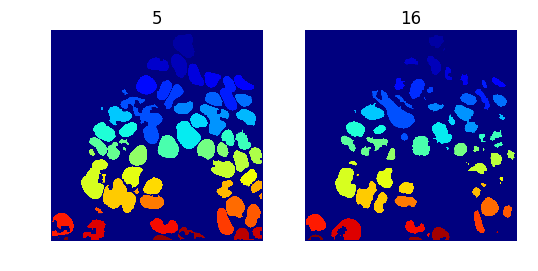

In [17]:
#Check results
plt.subplot(1,2,1),plt.imshow(final_stack[5])
plt.subplot(1,2,1),plt.axis('off')
plt.subplot(1,2,1),plt.title('5')
plt.subplot(1,2,2),plt.imshow(final_stack[22])
plt.subplot(1,2,2),plt.axis('off')
plt.subplot(1,2,2),plt.title('16')

In [18]:
##Save 3D Labelled mask as 'mask6'
mask6=final_stack
np.save('C:/Users/David Brown/Documents/Huang Lab/Exp0104_KDM5A_PHD2-fragments/Well02_HeLa_PHD2-IDR-PHD3_1/Well02_HeLa_PHD2-IDR-PHD3_1_mask6', mask6)

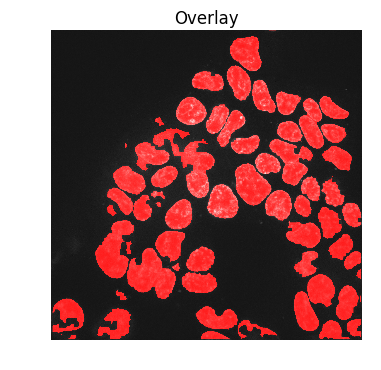

In [19]:
## Figure out Binary Overlays
plt.imshow(mh.overlay(Hoechst_stack[5], final_stack[5]))
plt.axis('off')
plt.title('Overlay')

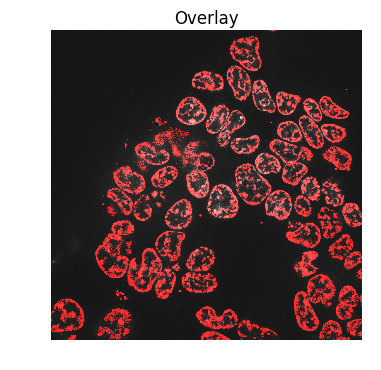

In [42]:
plt.imshow(mh.overlay(Hoechst_stack[5], mask5[5]))
plt.axis('off')
plt.title('Overlay')

In [261]:
##Select a single object

        #THIS DIDN'T WORK
        #from scipy.ndimage import measurements
        #nuc1=measurements.find_objects(relabeled,1)

#This did
nuc2=relabeled==2
nuc34=relabeled==34

In [518]:
##Save nuc34
np.save('C:/Users/David Brown/Documents/Huang Lab/Exp0104_KDM5A_PHD2-fragments/Well02_HeLa_PHD2-IDR-PHD3_1/Well02_HeLa_PHD2-IDR-PHD3_1_nuc34', nuc34)

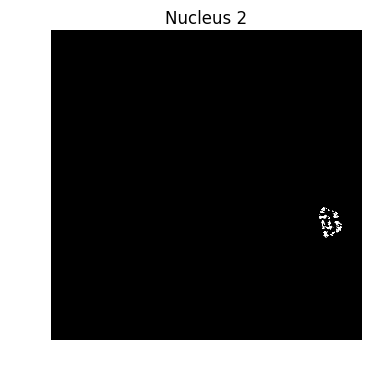

In [263]:
##Plot a single extracted object
plt.imshow(nuc34[8], cmap='gray')
plt.axis('off')
plt.title('Nucleus 2')

In [132]:
##Compute the convex hull of real objects (SLOW)
test_hull=morphology.convex_hull_object(nuc2[4], neighbors=8)

#Consider the following for speed improvement
#https://github.com/scikit-image/scikit-image/issues/1786

In [173]:
#Select an object label
lab=2

#backround is zero in relabelled
nuc=relabeled==lab

In [175]:
##Whilst isolated, objects can be dilated and eroded to close holes without merging
# -avoid if possible

In [ ]:
##Consider paralellizing loops
http://scikit-image.org/docs/stable/user_guide/tutorial_parallelization.html

In [245]:
##Compute the convex hull of real objects
##Must be a 2D array
def hull_3D(array):

    nuc_hull=np.zeros_like(nuc)
    for f, frame in enumerate(nuc):
        
        try:
            
            nuc_hull[f] = morphology.convex_hull_image(nuc[f]) #for finding convex hull of single object
            #nuc_hull[f] = morphology.convex_hull_object(nuc[f], neighbors=8) #consider for finding multiple objects
            print "frame "+str(f)
        # block raising an exception
        except ValueError:
            #what to do if slice has no points?
            print "this object has no pixels in frame "+str(f)
            nuc_hull[f] = np.zeros_like(frame)
            #pass # doing nothing on exception
        
    return nuc_hull

In [ ]:
##Combine nuc_hulls into a global hulls stack
    
nuc_hulls=np.zeros_like(relabeled)
#Try for four nuclei
for lab in range(1,int(n_left)+1):
    print(lab)
    
    nuc = relabeled==lab
    
    nuc_hull = hull_3D(nuc)*lab #preserve labels
    nuc_hulls = nuc_hull+nuc_hulls    

(<matplotlib.axes._subplots.AxesSubplot at 0x207f5c588>,
 <matplotlib.text.Text at 0x1b741c978>)

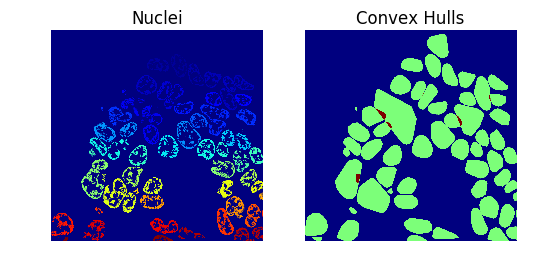

In [230]:
#Compare Input and Output
plt.subplot(1,2,1),plt.imshow(real[z])
plt.subplot(1,2,1),plt.axis('off')
plt.subplot(1,2,1),plt.title('Nuclei')
plt.subplot(1,2,2),plt.imshow(nuc_hulls[z])
plt.subplot(1,2,2),plt.axis('off')
plt.subplot(1,2,2),plt.title('Convex Hulls')

In [231]:
##Save Binary Nuclei, it takes a long time to run
io.imsave('C:/Users/David Brown/Documents/Huang Lab/Exp0104_KDM5A_PHD2-fragments/Well02_HeLa_PHD2-IDR-PHD3_1/Well02_HeLa_PHD2-IDR-PHD3_1_Binary_Nuclei.tif', nuc_hulls)

C:\Users\David Brown\Anaconda2\lib\site-packages\skimage\io\_io.py:132: UserWarning: C:/Users/David Brown/Documents/Huang Lab/Exp0104_KDM5A_PHD2-fragments/Well02_HeLa_PHD2-IDR-PHD3_1/Well02_HeLa_PHD2-IDR-PHD3_1_Binary_Nuclei.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


In [235]:
#Remove on border

##Relabel
labeled_hulls, n_hulls = mh.label(nuc_hulls)

(<matplotlib.axes._subplots.AxesSubplot at 0x1b7586748>,
 <matplotlib.text.Text at 0x1b77afd68>)

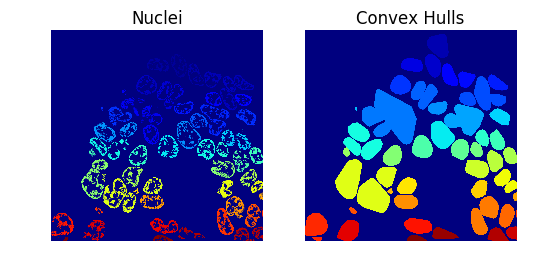

In [236]:
#Compare Input and Output
plt.subplot(1,2,1),plt.imshow(real[z])
plt.subplot(1,2,1),plt.axis('off')
plt.subplot(1,2,1),plt.title('Nuclei')
plt.subplot(1,2,2),plt.imshow(labeled_hulls[z])
plt.subplot(1,2,2),plt.axis('off')
plt.subplot(1,2,2),plt.title('Convex Hulls')

In [519]:
io.imsave('C:/Users/David Brown/Documents/Huang Lab/Exp0104_KDM5A_PHD2-fragments/Well02_HeLa_PHD2-IDR-PHD3_1/Well02_HeLa_PHD2-IDR-PHD3_1_Labeled_Nuclei.tif', labeled_hulls)

C:\Users\David Brown\Anaconda2\lib\site-packages\skimage\io\_io.py:132: UserWarning: C:/Users/David Brown/Documents/Huang Lab/Exp0104_KDM5A_PHD2-fragments/Well02_HeLa_PHD2-IDR-PHD3_1/Well02_HeLa_PHD2-IDR-PHD3_1_Labeled_Nuclei.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


In [238]:
##How can I deal with overlaps?
temp_hulls=nuc_hulls

##Check each hull for realistic volume
##Check for overlaps before adding to final stack.


In [253]:
#Try carrying label through convex fitting  - DOESN'T WORK YET
def convexhull(labeled_stack):

    #Change 'labeled_stack' to 'stack'

    ##Probably label the stack within this function as it is quick and then the number of objects can be passed forward.
    #labelled_stack, n_objects = mh.label(stack)

    lab_hulls=np.zeros_like(labeled_stack)

    #Change range to '(1,n_objects)'
    for lab in range(1,3):
        print(lab)

        nuc = labeled_stack==lab

        lab_hull = hull_3D(nuc)*lab    #multiplying by 'lab' should preserve the label
        lab_hulls = lab_hull+lab_hulls ##overlapping hulls will cause an ambiguity issue.
    return lab_hulls

In [254]:
lll=convexhull(relabeled)

1
frame 0
frame 1
frame 2
frame 3
frame 4
frame 5
frame 6
frame 7
frame 8
frame 9
frame 10
frame 11
frame 12
frame 13
frame 14
frame 15
frame 16
frame 17
frame 18
frame 19
frame 20
frame 21
frame 22
frame 23
2
frame 0
frame 1
frame 2
frame 3
frame 4
frame 5
frame 6
frame 7
frame 8
frame 9
frame 10
frame 11
frame 12
frame 13
frame 14
frame 15
frame 16
frame 17
frame 18
frame 19
frame 20
frame 21
frame 22
frame 23


(<matplotlib.axes._subplots.AxesSubplot at 0x1b8216b70>,
 <matplotlib.text.Text at 0x25fcf4ba8>)

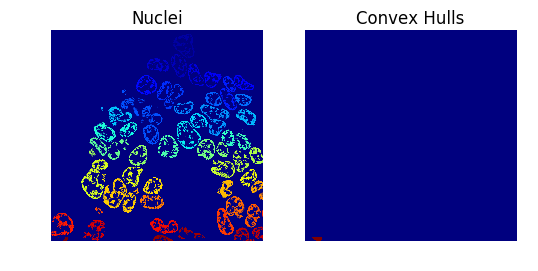

In [255]:
#Compare Input and Output
plt.subplot(1,2,1),plt.imshow(relabeled[z])
plt.subplot(1,2,1),plt.axis('off')
plt.subplot(1,2,1),plt.title('Nuclei')
plt.subplot(1,2,2),plt.imshow(lll[z])
plt.subplot(1,2,2),plt.axis('off')
plt.subplot(1,2,2),plt.title('Convex Hulls')

In [ ]:
##Orthogonal plot - NOT THE BEST APPROACH
#from mpl_toolkits.axes_grid1 import make_axes_locatable

#fig = plt.figure(figsize=(12, 12))

# xy projection:
#ax_xy = fig.add_subplot(111)
#ax_xy.imshow(real[z])

#divider = make_axes_locatable(ax_xy)
#ax_zx = divider.append_axes("top", 2, pad=0.2, sharex=ax_xy)
#ax_zx.imshow(real.mean(axis=1), aspect=z_scale/xy_scale)

#ax_yz = divider.append_axes("right", 2, pad=0.2, sharey=ax_xy)
#ax_yz.imshow(real.mean(axis=2).T, aspect=xy_scale/z_scale)

#plt.draw()

In [11]:
##Find Edges
import cv2 as cv

**Using an image from OpenCV with skimage**

If cv_image is an array of unsigned bytes, skimage will understand it by default. 

If you prefer working with floating point images, img_as_float() can be used to convert the image:

> from skimage import img_as_float

> image = img_as_float(any_opencv_image)

**Using an image from skimage with OpenCV**

The reverse can be achieved with img_as_ubyte():

> from skimage import img_as_ubyte

> cv_image = img_as_ubyte(any_skimage_image)

In [435]:
#Try finding contours in a test image
from skimage import img_as_ubyte

test=nuc34[8]

cv_test = img_as_ubyte(test)

#test is boolean
#contours,hierarchy = cv.findContours(test, 1, 2)
im2, contours, hierarchy = cv.findContours(cv_test, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

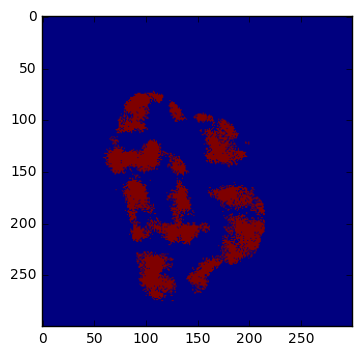

In [442]:
plt.imshow(im2[1100:1400,1700:2000])

In [366]:
#Only return external contours
im2, contours, hierarchy = cv.findContours(cv_test, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
curve = np.vstack(contours).squeeze()
#Note that cv2.findContours actually return 2 items. 
#"contours" here is a list. 
#So we use numpy's vstack() to stack them together, 
#followed by squeeze() to remove any redundant axis.


In [315]:
curve_plot = np.zeros_like(cv_test)
curve_plot[curve[:,1],curve[:,0]]=1

In [377]:
#cnt=contours[0] #probably only works when you have a single solid object
#cnt
#contours = np.vstack(contours).squeeze()
curve.shape

(2190L, 2L)

In [406]:
#Input vector of a 2D point stored in std::vector or Mat
epsilon=1.2

poly = cv.approxPolyDP(curve, epsilon, True) #poly is for opencv
pts = np.vstack(poly).squeeze()              #pts is for skimage

In [409]:
poly_plot = np.zeros_like(cv_test)
poly_plot[pts[:,1],pts[:,0]]=1

In [410]:
pts.shape

(820L, 2L)

(<matplotlib.axes._subplots.AxesSubplot at 0x329adcf60>,
 <matplotlib.text.Text at 0x33e0926d8>)

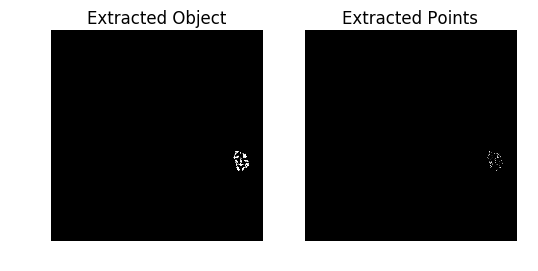

In [411]:
#plot the curve
plt.subplot(1,2,1),plt.imshow(nuc34[8], cmap='gray')
plt.subplot(1,2,1),plt.axis('off')
plt.subplot(1,2,1),plt.title('Extracted Object')
plt.subplot(1,2,2),plt.imshow(curve_plot, cmap='gray')
plt.subplot(1,2,2),plt.axis('off')
plt.subplot(1,2,2),plt.title('Extracted Points')

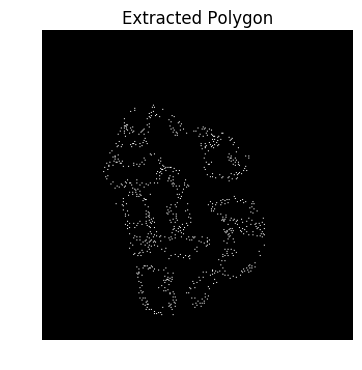

In [443]:
### Compare to the polygon points
plt.imshow(poly_plot[1100:1400,1700:2000], cmap='gray')
plt.axis('off')
plt.title('Extracted Polygon')

In [433]:
#plot the polygon
#poly_line = cv.polylines(null,poly,True,(0,255,0),10)
poly_line = cv.polylines(null,poly,True,(0,0,255))

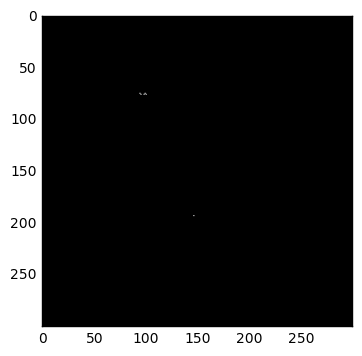

In [444]:
plt.imshow(poly_line[1100:1400,1700:2000], cmap='gray')

(array([1174, 1174, 1175, ..., 1374, 1375, 1375], dtype=int64),
 array([1807, 1808, 1792, ..., 1811, 1816, 1825], dtype=int64))

In [317]:
poly_line=cv.drawContours(null, poly, -1, (0, 255, 0), 3)

error: OpenCV(3.4.2) C:\projects\opencv-python\opencv\modules\imgproc\src\drawing.cpp:2515: error: (-215:Assertion failed) npoints > 0 in function 'cv::drawContours'


In [49]:
cnt = contours[4]
null = np.zeros_like(cv_test)
#Draw contours over original image
#cv_cnt=cv.drawContours(cv_test, [cnt], 0, (0,255,0), 3)
#cv_cnt=cv.drawContours(image, contours, contourIdx, color[, thickness[, lineType[, hierarchy[, maxLevel[, offset]]]]])
#cv_cnt=cv.drawContours(null, [cnt], 0, (255,255,255), 1)
cv_cnt=cv.drawContours(cv_test, contours, 4, (255,255,255))

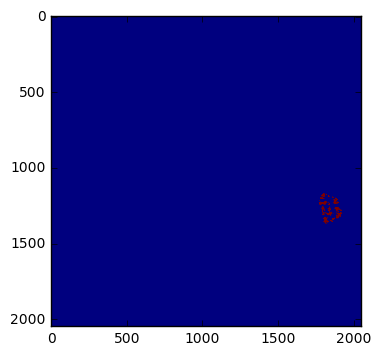

In [279]:
from skimage import img_as_float

test_cnt = img_as_float(cv_cnt)

plt.imshow(test_cnt)

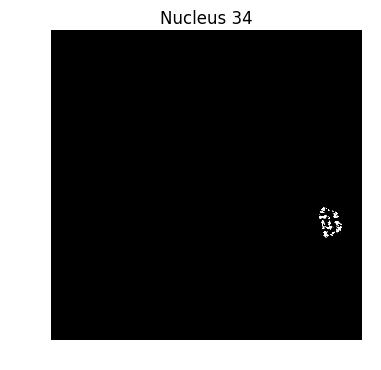

In [480]:
##Plot a single extracted object
test=nuc34[8]
plt.imshow(test, cmap='gray')
plt.axis('off')
plt.title('Nucleus 34')

In [451]:
dilated=mh.borders(nuc34[8],30)

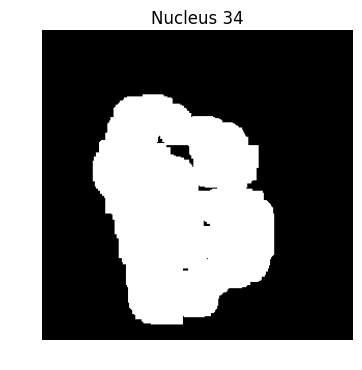

In [472]:
plt.imshow(blob[1100:1400,1700:2000], cmap='gray')
plt.axis('off')
plt.title('Nucleus 34')

In [493]:
#convert image to coordinates
dots=nuc34[8].nonzero()
dots

(array([1173, 1174, 1174, ..., 1375, 1375, 1375], dtype=int64),
 array([1807, 1807, 1808, ..., 1816, 1825, 1826], dtype=int64))

In [456]:
rpos, cpos = nuc34[8].nonzero()

In [457]:
rpos

array([1173, 1174, 1174, ..., 1375, 1375, 1375], dtype=int64)

In [458]:
#Get max and min columns for each row
for r in len(dots):
    row=
    cmin= min

In [486]:
from scipy.ndimage import morphology

In [487]:
blob=morphology.binary_dilation(test, np.ones((20,20)))
filled_blob=morphology.binary_fill_holes(blob)
reduced=morphology.binary_erosion(filled_blob, np.ones((20,20)))

(<matplotlib.axes._subplots.AxesSubplot at 0x384c8dbe0>,
 <matplotlib.text.Text at 0x3853224a8>)

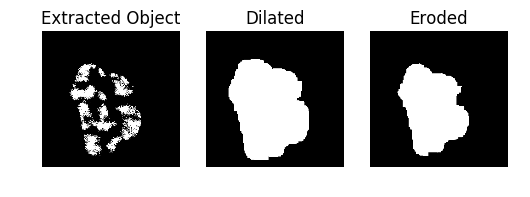

In [488]:
##Compare
plt.subplot(1,3,1),plt.imshow(test[1100:1400,1700:2000], cmap='gray')
plt.subplot(1,3,1),plt.axis('off')
plt.subplot(1,3,1),plt.title('Extracted Object')
plt.subplot(1,3,2),plt.imshow(filled_blob[1100:1400,1700:2000], cmap='gray')
plt.subplot(1,3,2),plt.axis('off')
plt.subplot(1,3,2),plt.title('Dilated')
plt.subplot(1,3,3),plt.imshow(reduced[1100:1400,1700:2000], cmap='gray')
plt.subplot(1,3,3),plt.axis('off')
plt.subplot(1,3,3),plt.title('Eroded')

In [514]:
boarder = measure.marching_cubes(reduced, 1)

ValueError: Input volume must have 3 dimensions.

IndexError: index 1 is out of bounds for axis 1 with size 1

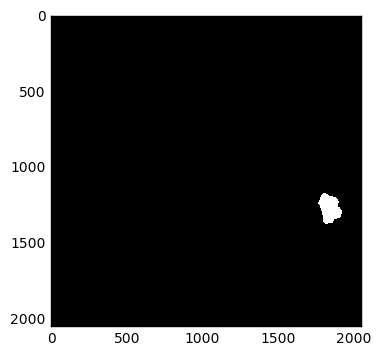

In [512]:
##Get boarder
from skimage import measure

# Find contours at a constant value of 0.8
#boarder = measure.find_contours(reduced, 0.6)

boarder = measure.marching_cubes(reduced)

#boarder = measure.approximate_polygon()

# Display the image and plot all contours found
fig, ax = plt.subplots()
ax.imshow(reduced, interpolation='nearest', cmap=plt.cm.gray)

for n, contour in enumerate(contours):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [495]:
new_poly=mh.fill_polygon(dots, null, color=1)
#http://pydoc.net/mahotas/1.4.3/mahotas.polygon/
plt.imshow(new_poly[1100:1400,1700:2000])

AttributeError: 'module' object has no attribute 'fill_polygon'

C:\Users\David Brown\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
  if __name__ == '__main__':


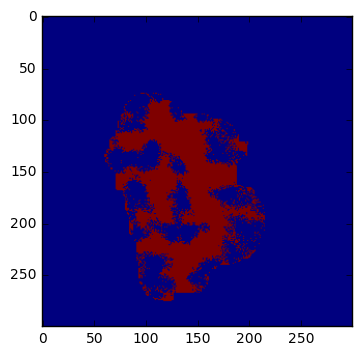

In [503]:
plt.imshow(reduced[1100:1400,1700:2000]-test[1100:1400,1700:2000])